In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy, AUC
import argparse
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from keras.utils import plot_model

In [ ]:
data_dir = "/content/gdrive/MyDrive/Colab Notebooks/Data/"
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = tf.keras.utils.image_dataset_from_directory("/content/gdrive/MyDrive/Colab Notebooks/Data/")

Found 918 files belonging to 3 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)
test_size = int(len(data)*.2)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
n_classes = 3

In [ ]:
dnn_model = Sequential()

imported_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=3,)
for layer in imported_model.layers:
        layer.trainable=False

dnn_model.add(Normalization())
dnn_model.add(Resizing(256, 256))
dnn_model.add(RandomFlip("horizontal"))
dnn_model.add(RandomRotation(factor=0.02))
dnn_model.add(RandomZoom(height_factor=0.2, width_factor=0.2))
dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(n_classes, activation='softmax'))
dnn_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = dnn_model.fit(
  train,
  validation_data=val,
  epochs=20
)

Epoch 1/20
20/20 [==============================] - 243s 11s/step - loss: 1.0157 - accuracy: 0.5188 - val_loss: 1.0368 - val_accuracy: 0.5156
Epoch 2/20
20/20 [==============================] - 231s 11s/step - loss: 1.0782 - accuracy: 0.4703 - val_loss: 1.1958 - val_accuracy: 0.2031
Epoch 3/20
20/20 [==============================] - 234s 11s/step - loss: 1.0333 - accuracy: 0.5172 - val_loss: 1.0486 - val_accuracy: 0.4844
Epoch 4/20
20/20 [==============================] - 230s 11s/step - loss: 1.0114 - accuracy: 0.5063 - val_loss: 1.2407 - val_accuracy: 0.4062
Epoch 5/20
20/20 [==============================] - 231s 11s/step - loss: 0.9995 - accuracy: 0.5375 - val_loss: 1.0929 - val_accuracy: 0.4844
Epoch 6/20
20/20 [==============================] - 231s 11s/step - loss: 1.0450 - accuracy: 0.4844 - val_loss: 0.9663 - val_accuracy: 0.5625
Epoch 7/20
20/20 [==============================] - 227s 11s/step - loss: 1.0398 - accuracy: 0.5078 - val_loss: 1.0955 - val_accuracy: 0.3750
Epoch 

In [ ]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()
labels = {'HSIL':0,'LSIL':1,'NSIL':2}

In [ ]:
def testing(model):
  pre = Precision()
  re = Recall()
  acc = SparseCategoricalAccuracy()
  pred = []
  y_test = []
  for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_test.append(y)
    yhat = np.argmax(model.predict(X), axis=1)
    pred.append(yhat)
    xy=model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, xy)

  pred = np.array(pred)
  pred = pred.reshape((pred.size,))
  y_test = np.array(y_test)
  y_test = y_test.reshape((y_test.size,))
  print(accuracy_score(y_test, pred))
  ConfusionMatrixDisplay.from_predictions(y_test, pred)
  tf.keras.utils.plot_model(model,show_shapes=True)
  print(classification_report(y_test, pred, target_names=labels))

1/1 [==============================] - 6s 6s/step
0.49375


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        HSIL       0.00      0.00      0.00        43
        LSIL       0.67      0.19      0.29        43
        NSIL       0.48      0.96      0.64        74

    accuracy                           0.49       160
   macro avg       0.38      0.38      0.31       160
weighted avg       0.40      0.49      0.37       160



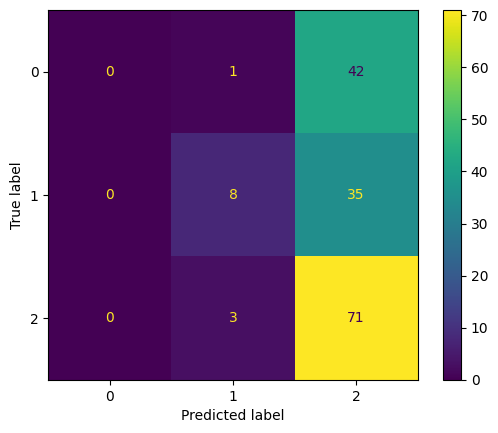

In [ ]:
testing(dnn_model)

In [ ]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 256, 256, 3)      7         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              2

In [2]:
history.save(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/models",'resnet_01.h5'))

NameError: ignored